In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploration :)

f_name, 0 
food_type, 1 
starve_period, 2 
xcm, 3 
xcm_dot,
ycm,
ycm_dot,
num_meals, 7 
tot_vol,
dur_eating, 
eat_latency, 10
meal_num,
start_time, 12
end_time, 13
meal_dur,
meal_vol, 15
t, 16

In [2]:
data = np.load('newrawdata.npy',allow_pickle=True)
flynum = data[1].shape[0] #384

In [3]:
food_type = data[1]
starve_period = data[2]

xcm = data[3] #x center of mass location
ycm = data[5]
xcm_dot = data[4] #x center of mass velocity
ycm_dot = data[6]

eat_latency = data[10]
start_time = data[12]
meal_vol = data[15]

t_offset = 1.0/3.0 
t = data[16] - t_offset

### Find Conditions

In [4]:
#By Foodtype
mM1000 = np.where(food_type == '1000mM')[0] #(90,)
mM100 = np.where(food_type == '100mM')[0]
mM10 = np.where(food_type == '10mM')[0]
mM1 = np.where(food_type == '1mM')[0]  #(48,)
mMwater = np.where(food_type == 'water')[0]

In [5]:
#By starvetime
st_0 = np.where(starve_period == '0')[0]
st_8 = np.where(starve_period == '8')[0]
st_16 = np.where(starve_period == '16')[0]
st_24 = np.where(starve_period == '24')[0]
st_32 = np.where(starve_period == '32')[0]

In [6]:
#Volume of first bout 
vol_first = np.array([meal_vol[i][0] for i in range(flynum)])

## Calculate Thoroughness Index

In [7]:
# ? seconds before 1st meal -> 1st meal
first_meal_start = np.array([start_time[i][0] for i in range(flynum)])

# get that trajectory
x_traj = []
y_traj = []
for i in range(flynum):
    idx = (t[i] >= (first_meal_start[i] - 10)) & (t[i] <= first_meal_start[i])   #10 seconds before 1st meal
    x_traj.append(xcm[i][idx])
    y_traj.append(ycm[i][idx])
x_traj = np.array(x_traj,dtype=object)
y_traj = np.array(y_traj,dtype=object)

def traj(flyno):
    return np.vstack((x_traj[flyno], y_traj[flyno])).T

Compute the length of the continuous path;
The total length of L from (x0, y0) to (xn-1, yn-1) is given by:
L = ∑i=1,...,n-1 sqrt[ (xi - xi-1)2 + (yi - yi-1)2 ]

In [8]:
def Length(flyno):
    flytraj = traj(flyno)
    lengths = np.sqrt(np.sum(np.diff(flytraj, axis=0)**2, axis=1)) # Total length: L
    return np.sum(lengths)    

In [9]:
def radius(flyno):
    flytraj = traj(flyno)    
    from scipy import spatial
    cand = flytraj[spatial.ConvexHull(flytraj).vertices]
    dist_mat = spatial.distance_matrix(cand, cand)
    i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
    #print(cand[i], cand[j])
    import math
    dist = math.hypot(cand[j][0] - cand[i][0], cand[j][1] - cand[i][1])
    r = dist/2
    return r

In [10]:
w = 1/10 #assume width of flies' body = 1mm

In [11]:
def thoroughnessind(L,r,w = 1/10):
    return 1- np.exp(((-4)*L*w)/(np.pi* (r**2)))

def all_t(cond):
    "cond = st_0"
    t_all = []
    for n in cond:
        L = Length(n)
        r = radius(n)
        t = thoroughnessind(L,r,w = 1/10)
        #print('fly: ' + str(n) + ' t: '+ str(t))
        t_all.append(t)
    return np.array(t_all)

## Thoroughness Index against 'Starved Time'

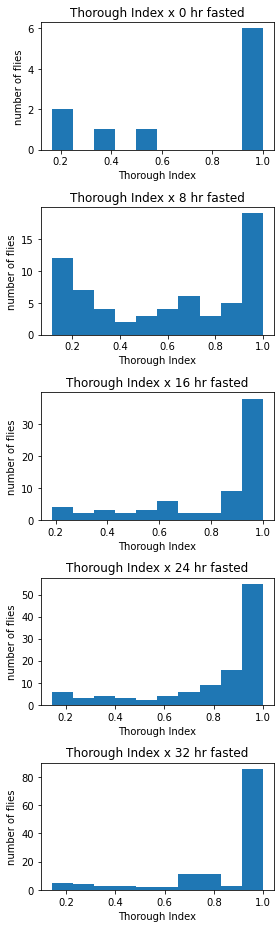

In [12]:
plt.figure(figsize=(4,13))
all_starv = [st_0, st_8, st_16, st_24, st_32]
for j in range(len((all_starv))):
    plt.subplot(5,1,j+1)
    plt.hist(all_t(all_starv[j]))
    plt.title('Thorough Index x ' + str(0+j*8) + ' hr fasted')
    plt.ylabel('number of flies')
    plt.xlabel('Thorough Index')
    plt.tight_layout()

## Thoroughness Index against 'sugar conc'

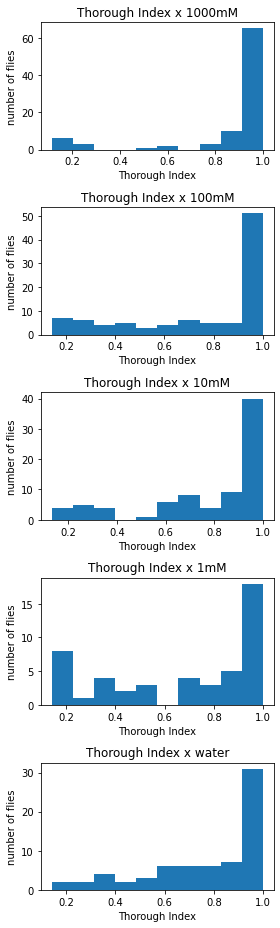

In [13]:
plt.figure(figsize=(4,13))
all_conc = [mM1000, mM100, mM10, mM1, mMwater]
fortitle = ['1000mM', '100mM','10mM','1mM','water']
for j in range(len((all_conc))):
    plt.subplot(5,1,j+1)
    plt.hist(all_t(all_conc[j]))
    plt.title('Thorough Index x ' + str(fortitle[j]))
    plt.ylabel('number of flies')
    plt.xlabel('Thorough Index')
    plt.tight_layout()

## Thoroughness Index against 'volume of first meal'

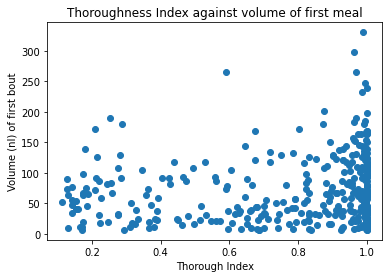

In [14]:
allflies_tind = all_t(np.arange(flynum)) #get thoroughness index for all individual 384 flies

plt.scatter(allflies_tind, vol_first)
plt.ylabel('Volume (nl) of first bout')
plt.xlabel('Thorough Index')
plt.title('Thoroughness Index against volume of first meal')
plt.show()

## Ignore the rest, thanks!

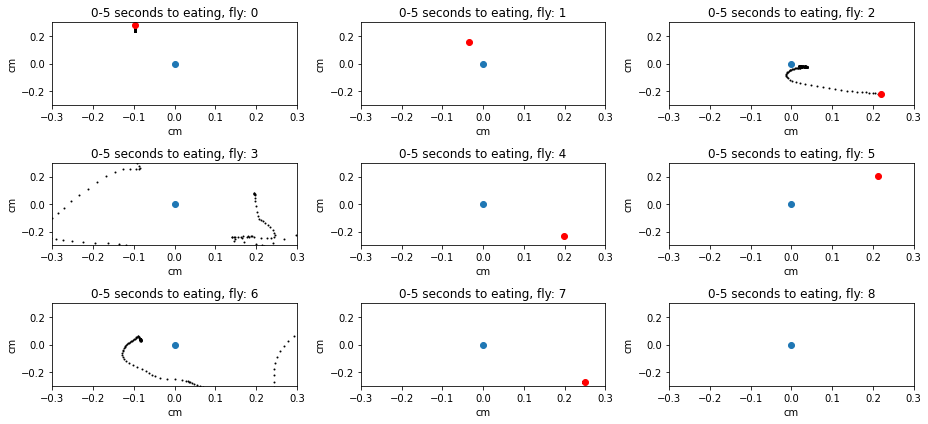

In [142]:
# plot trajectories
plt.figure(figsize=(13,6))
for j in range(9): #look at 10 flies
    plt.subplot(3,3,j+1)
    plt.scatter(traj_list[j][0], traj_list[j][1], color = 'black', s = 1, alpha=1)
    plt.scatter(traj_list[j][0][0], traj_list[j][1][0], color = 'red')  # start point
    plt.title('0-5 seconds to eating, fly: ' +str(j) )
    plt.scatter(0,0)
    plt.xlabel('cm')
    plt.ylabel('cm')
    plt.ylim(-0.3,0.3)
    plt.xlim(-0.3,0.3)
    plt.tight_layout()

## Simple Linear Regression Model

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [127]:
latency_toeat = np.array(raw_df['eat_latency']) #X1
starve_period = np.array(raw_df['starve_period']) #X2

NameError: name 'raw_df' is not defined

In [ ]:
food = np.array(raw_df['food_type']) 
food_type = np.zeros(latency_toeat.shape[0])  #X3
for m in range(latency_toeat.shape[0]):
    if food[m] == 'water':
        food_type[m] = 0
    else:
        food_type[m] = int(food[m].split('mM')[0])

In [128]:
firstvol = np.zeros(latency_toeat.shape[0])   #y
for m in range(latency_toeat.shape[0]):
    firstvol[m] = float(str(np.array(raw_df['meal_vol'])[m])[1:-1].split(' ')[0])

NameError: name 'latency_toeat' is not defined

In [70]:
X = np.vstack((latency_toeat, food_type, starve_period)).T
y = firstvol

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.33, random_state=12)

In [71]:
model_lr = LinearRegression().fit(X_trn, y_trn) 
model_lr.score(X_tst, y_tst)

0.217320266204878

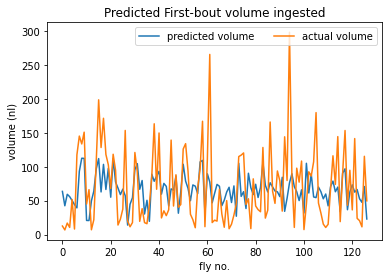

In [72]:
pred = model_lr.predict(X_tst)
act = y_tst
plt.title('Predicted First-bout volume ingested')
plt.plot(pred,label='predicted volume')
plt.plot(act,label='actual volume')
plt.legend(ncol=2)
plt.ylabel('volume (nl)')
plt.xlabel('fly no.')
plt.show()